# Task 3 - Basic Models

In [1]:
from ift6758.data.nhl_data_parser import NHLDataParser
from sklearn.metrics import accuracy_score
from sklearn.linear_model import LogisticRegression
import numpy as np
import pickle
from sklearn.metrics import  RocCurveDisplay
from sklearn.calibration import CalibrationDisplay
import matplotlib.pyplot as plt
import os



In [2]:
# Load the data
data_parser = NHLDataParser()
train_df = data_parser.get_shot_and_goal_pbp_df_for_seasons(2016, 2018, with_playoff_season=False)
val_df = data_parser.get_shot_and_goal_pbp_df_for_season(2019, with_playoff_season=False)
test_df = data_parser.get_shot_and_goal_pbp_df_for_season(2020, with_playoff_season=False)

In [3]:
# load path and make dirs to store model
model_path = os.getenv("MODEL_PATH") #edit .env file to change path
logistic_path = os.path.join(model_path, "logistic_regression")
if not os.path.exists(logistic_path):
    os.makedirs(logistic_path)

## Logistic Regression 1: Only using distance

In [4]:
X_train = train_df[['shotDistance']]
y_train = train_df['isGoal']
X_val = val_df[['shotDistance']]
y_val = val_df['isGoal']
clf_log1 = LogisticRegression().fit(X_train, y_train) 
predictions_1 = clf_log1.predict(X_val)
prob_scores_1 = clf_log1.predict_proba(X_val)[:,1]
print('Accuracy:', accuracy_score(y_val, predictions_1))
model_1_path = os.path.join(logistic_path, "lg_distance.pkl")
with open(model_1_path, 'wb') as f:
    pickle.dump(clf_log1, f)

Accuracy: 0.9030369396992262


## Logistic Regression 2: Only using Angle

In [5]:
X_train = train_df[['shotAngle']]
y_train = train_df['isGoal']
X_val = val_df[['shotAngle']]
y_val = val_df['isGoal']
clf_log2 = LogisticRegression().fit(X_train, y_train) 
predictions_2 = clf_log2.predict(X_val)
prob_scores_2 = clf_log2.predict_proba(X_val)[:,1]
print('Accuracy:', accuracy_score(y_val, predictions_2))
model_2_path = os.path.join(logistic_path, "lg_angle.pkl")
with open(model_2_path, 'wb') as f:
    pickle.dump(clf_log2, f)

Accuracy: 0.9030369396992262


## Logistic Regression 3: Using both Angle and Distance

In [6]:
X_train = train_df[['shotDistance', 'shotAngle']]
y_train = train_df['isGoal']
X_val = val_df[['shotDistance', 'shotAngle']]
y_val = val_df['isGoal']
clf_log3 = LogisticRegression().fit(X_train, y_train) 
predictions_3 = clf_log3.predict(X_val)
prob_scores_3 = clf_log3.predict_proba(X_val)[:,1]
print('Accuracy:', accuracy_score(y_val, predictions_3))
model_3_path = os.path.join(logistic_path, "lg_distance_angle.pkl")
with open(model_3_path, 'wb') as f:
    pickle.dump(clf_log3, f)


Accuracy: 0.9030369396992262


## Graphs

In [7]:
#Collect all the probabilities
prob_scores = [('Distance',prob_scores_1), ('Angle',prob_scores_2), ('Angle and Distance',prob_scores_3)]

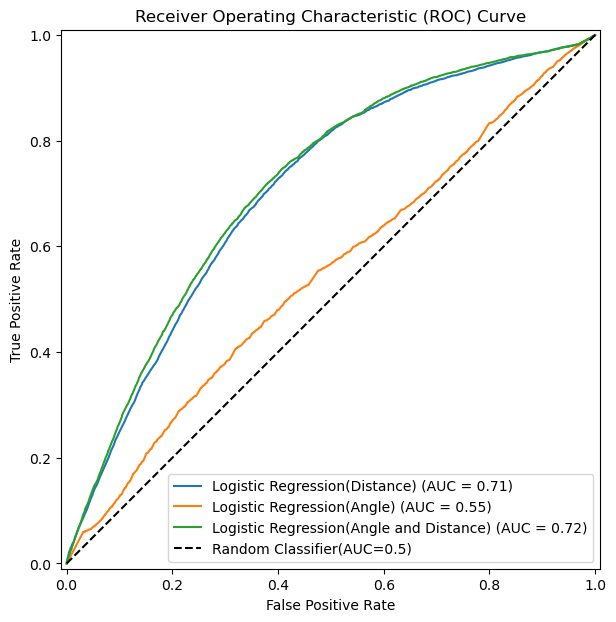

In [8]:
#Graph 1: Roc Curve

fig_1, ax_1 = plt.subplots()
roc = {}
plot_random = False #This is just to make sure that the random classifier is only plotted once

#Plot the ROC curve for each classifier
for name , prob_score in prob_scores:
    if name == 'Angle and Distance': #Only plot the random classifier once at the end
        plot_random = True  
    roc[name] = RocCurveDisplay.from_predictions(y_val, prob_score , plot_chance_level=plot_random, ax=ax_1,name=f'Logistic Regression({name})',chance_level_kw={'label':'Random Classifier(AUC=0.5)'})
ax_1.set_title('Receiver Operating Characteristic (ROC) Curve')
ax_1.set_xlabel('False Positive Rate')
ax_1.set_ylabel('True Positive Rate')
fig_1.set_size_inches(7,7)





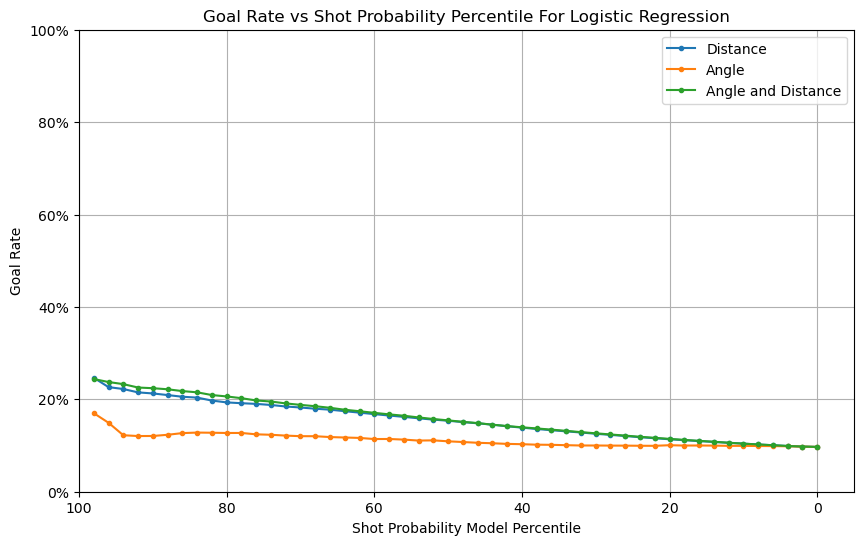

In [9]:
#Graph 2: Goal Rate as a Function of Shot Probability Model Percentile

# Calculate the percentiles for the shot probabilities for all models
percentile_bins = np.arange(0, 100, 2)
percentiles = {}
for name, prob_score in prob_scores:
    percentile_data = np.percentile(prob_score , percentile_bins)
    percentiles[name] = percentile_data


# Calculate the goal rates for each percentile for all models
goal_rates = {}
for name, prob_score in prob_scores:
    goal_rates[name] = []
    for percentile in percentiles[name]:
        mask = prob_score  >= percentile
        goal_rates[name].append(y_val[mask].mean())


# Plot the goal rate as a function of the shot probability model percentile for all models

fig_2, ax_2 = plt.subplots()
for name, goal_rate in goal_rates.items():
    ax_2.plot(percentile_bins, goal_rate, marker='.', label=name)
plt.xlabel('Shot Probability Model Percentile')
plt.ylabel('Goal Rate')
plt.title('Goal Rate vs Shot Probability Percentile For Logistic Regression')
plt.grid(True)
plt.legend()
plt.ylim(0, 1)
plt.gca().yaxis.set_major_formatter(plt.FuncFormatter(lambda y, _: '{:.0%}'.format(y)))
plt.xlim(100, -5)
fig_2.set_size_inches(10,6)
plt.show()



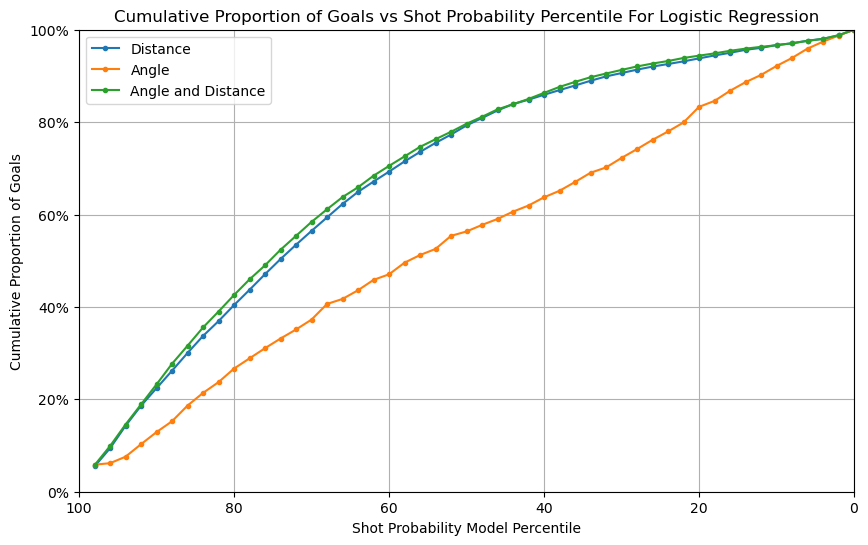

In [10]:
# Graph 3: Cumulative Proportion of Goals as a Function of Shot Probability Model Percentile 

# Calculate the cumulative goal percentage for each percentile for all models
cumulative_goal_proportions = {}
for name, prob_score in prob_scores:
    cumulative_goal_proportions[name] = []
    for percentile in percentiles[name]:
        mask = prob_score  >= percentile
        cumulative_goal_proportions[name].append(y_val[mask].sum() / y_val.sum())


# Plot the cumulative proportion of goals as a function of the shot probability model percentile for all models
fig_3, ax_3 = plt.subplots()
for name, cumulative_goal_proportion in cumulative_goal_proportions.items():
    ax_3.plot(percentile_bins, cumulative_goal_proportion, marker='.', label=name)
plt.xlabel('Shot Probability Model Percentile')
plt.ylabel('Cumulative Proportion of Goals')
plt.title('Cumulative Proportion of Goals vs Shot Probability Percentile For Logistic Regression')
plt.grid(True)
plt.ylim(0, 1)
plt.gca().yaxis.set_major_formatter(plt.FuncFormatter(lambda y, _: '{:.0%}'.format(y)))
plt.xlim(100, 0)
plt.legend()
fig_3.set_size_inches(10,6)
plt.show()

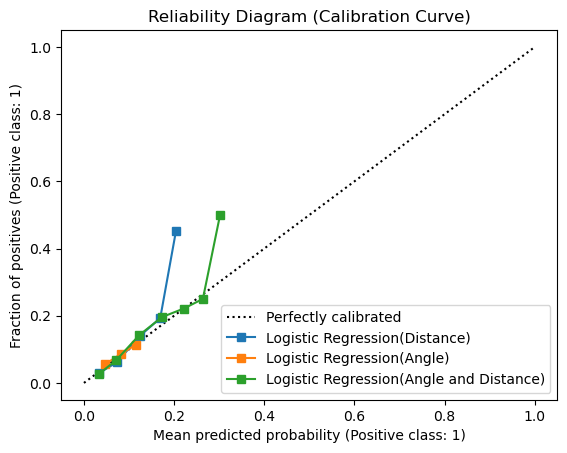

In [11]:
# Graph 4: Calibration Curve
fig_4,ax_4 = plt.subplots()
#Plot the calibration curve for each classifier
for name, prob_score in prob_scores:
    CalibrationDisplay.from_predictions(y_val, prob_score, n_bins=20, strategy='uniform',ax=ax_4,name=f'Logistic Regression({name})')
plt.title('Reliability Diagram (Calibration Curve)')
plt.show()

## Log Everything Using Wandb

## 

In [ ]:
from ift6758.data.data_logger import DataLogger
api_key = os.getenv("WANDB_API_KEY") #REMEMBER TO SET YOUR API KEY IN THE ENVIRONMENT VARIABLES BUT NOT PUSH IT TO GITHUB
logger = DataLogger(project_name="IFT6758.2024-B08",entity='team08',group = 'logistic_regression',API_KEY=api_key)

Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.
wandb: Using wandb-core as the SDK backend. Please refer to https://wandb.me/wandb-core for more information.
wandb: Currently logged in as: jorawar-singh-dham (team08). Use `wandb login --relogin` to force relogin
wandb: WARNING If you're specifying your api key in code, ensure this code is not shared publicly.
wandb: WARNING Consider setting the WANDB_API_KEY environment variable, or running `wandb login` from the command line.
wandb: Appending key for api.wandb.ai to your netrc file: C:\Users\gogig\_netrc


In [13]:
#Collect data to pass through the logger
models =[(model_1_path, 'lg_distance'),(model_2_path, 'lg_angle'),(model_3_path, 'lg_angle_distance')]
figures = [(fig_1,'ROC'),(fig_2,'goal_rate_probpercentile'),(fig_3,'cum_probpercentile'),(fig_4,'calibration_curve')]

In [14]:
#Log the models and figures
# logger.log_models(models)
logger.log_figures(figures)